# Imports

In [3]:
# Basics
import numpy as np
import pandas as pd
import os

# Scikit Learn
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC

# Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, Embedding
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Charts
import matplotlib.pyplot as plt
%matplotlib inline

# Functions

In [2]:
def tokenize(df, max_num_words, max_sequence_length):
    '''
    Take in a DataFrame of text data, cap number of words and sequence length
    pad sequences for LSTM
    '''
    tokenizer = Tokenizer(num_words=max_num_words)
    tokenizer.fit_on_texts(df['sentence'].values)
    sequences = tokenizer.texts_to_sequences(df['sentence'].values)
    word_index = tokenizer.word_index
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)
    
    return padded_sequences, word_index, tokenizer

In [8]:
def vectorize(max_num_words, embedding_dim, word_index):
    '''
    Vectorize words in the gloVe vector space specified
    gives embedding index for use by the embed function
    '''
    glove_dir = './glove.6B'
    embedding_index = {}

    with open(os.path.join(glove_dir, 'glove.6B.300d.txt')) as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = coefs
    
    return embedding_index

In [4]:
def embed(max_num_words, embedding_index, embedding_dim, word_index):
    '''
    Embed words into the gloVe vector space
    '''
    embedding_matrix = np.zeros((max_num_words, embedding_dim))
    for word, index in word_index.items():
        if index < max_num_words:
            # Using "get" with the dict is a safe way to avoid missing key errors
            embedding_vector = embedding_index.get(word) 
            if embedding_vector is not None:
                embedding_matrix[index] = embedding_vector
    
    return embedding_matrix

# Read-in Data

In [6]:
# Load data specified in 'file'
file = './data/data60.csv'
data = pd.read_csv(file)
data.drop(['Unnamed: 0'], axis=1, inplace=True)
print(data.shape)
data.head()

(18820, 3)


,sentence,author,title
0,in the late summer of that year we lived in a ...,hemingway,a farewell to arms
1,in the bed of the river there were pebbles and...,hemingway,a farewell to arms
2,troops went by the house and down the road and...,hemingway,a farewell to arms
3,the trunks of the trees too were dusty and the...,hemingway,a farewell to arms
4,the plain was rich with crops there were man...,hemingway,a farewell to arms


# Embed Data

In [9]:
# Set parameters
max_sequence_length = 100 # Max input
max_num_words = 150000 # Available gloVe lexicon
embedding_dim = 300 # Dimension of gloVe vector space

# Tokenize and vectorize the data
padded_sequences, word_index, tokenizer = tokenize(data, max_num_words, max_sequence_length)
embedding_index = vectorize(max_num_words, embedding_dim, word_index)
embedding_matrix = embed(max_num_words, embedding_index, embedding_dim, word_index)

In [13]:
# Setup X
X = padded_sequences

# Setup y
y = data['author']
le = LabelEncoder()
y = le.fit_transform(y)
y = y.reshape(-1, 1)
oe = OneHotEncoder(sparse=False)
y = oe.fit_transform(y)

# Dimension to be used in LSTM
output_shape = le.classes_.shape[0]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y)

# LSTM Modeling

Foundational layer setup of Long Short Term Memory model.

In [14]:
lstm = Sequential()
lstm.add(Embedding(max_num_words, embedding_dim, input_length=max_sequence_length))
lstm.add(LSTM(9, recurrent_dropout=0.5, dropout=0.5))
lstm.add(Dense(output_shape, activation='softmax'))

# Use the pre-trained GloVe weights, which are here called `embedding_matrix`, in the model.
lstm.layers[0].set_weights([embedding_matrix])

lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          45000000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 9)                 11160     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 40        
Total params: 45,011,200
Trainable params: 45,011,200
Non-trainable params: 0
_________________________________________________________________


In [15]:
epoch_count = 6

# Fit the model
lstm_output = lstm.fit(X_train, y_train, 
                   epochs=epoch_count, 
                   batch_size=max_sequence_length, 
                   validation_data=(X_test, y_test))

Train on 14115 samples, validate on 4705 samples
Epoch 1/6
14115/14115 [==============================] - 200s 14ms/step - loss: 0.5468 - acc: 0.7515 - val_loss: 0.5048 - val_acc: 0.7685
Epoch 2/6
14115/14115 [==============================] - 207s 15ms/step - loss: 0.4740 - acc: 0.7779 - val_loss: 0.4165 - val_acc: 0.8083
Epoch 3/6
14115/14115 [==============================] - 202s 14ms/step - loss: 0.3982 - acc: 0.8208 - val_loss: 0.3629 - val_acc: 0.8408
Epoch 4/6
14115/14115 [==============================] - 206s 15ms/step - loss: 0.3268 - acc: 0.8638 - val_loss: 0.3262 - val_acc: 0.8629
Epoch 5/6
14115/14115 [==============================] - 210s 15ms/step - loss: 0.2608 - acc: 0.8969 - val_loss: 0.3074 - val_acc: 0.8717
Epoch 6/6
14115/14115 [==============================] - 206s 15ms/step - loss: 0.2122 - acc: 0.9203 - val_loss: 0.3045 - val_acc: 0.8745


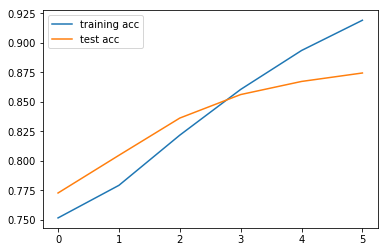

In [19]:
# Plot results
lstm_train_loss = lstm_output.history['acc']
lstm_test_loss = lstm_output.history['val_acc']
plt.plot(lstm_train_loss, label='training acc')
plt.plot(lstm_test_loss, label='test acc')
plt.legend();

In [20]:
# Get history data for plotting later
for i in lstm_output.history['acc']:
    print(i)

0.7516117590013397
0.7792242249613149
0.8217499098624061
0.8605030088233813
0.8934998195347869
0.919146302254792


In [21]:
# More data for plotting
for i in lstm_output.history['val_acc']:
    print(i)

0.7727417525905605
0.804675880388043
0.8362380422010431
0.8561636596506385
0.867268865217438
0.8744420808889407


# GRU  Modeling

In [100]:
# gru = Sequential()
# gru.add(Embedding(max_num_words, embedding_dim, input_length=max_sequence_length))
# gru.add(GRU(4))
# gru.add(Dense(output_shape, activation='softmax'))

# # Use the pre-trained GloVe weights, which are here called `embedding_matrix`, in the model.
# gru.layers[0].set_weights([embedding_matrix])

# gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# gru.summary()

In [99]:
# epoch_count = 5

# # Fit the model
# gru_output = gru.fit(X_train, y_train,
#                      epochs=epoch_count,
#                      batch_size=max_sequence_length,
#                      validation_data=(X_test, y_test))

# # Plot results
# gru_train_loss = gru_output.history['loss']
# gru_test_loss = gru_output.history['val_loss']
# plt.plot(gru_train_loss, label='training accuracy')
# plt.plot(gru_test_loss, label='test accuracy')
# plt.legend();

# SVC

In [65]:
svc = SVC(gamma=0.001, C=1)
cross_val_score(svc, X_train, y_train, cv=5, scoring='accuracy').mean()

# Check

In [434]:
file = './targets.csv'
check = pd.read_csv(file)
check.drop(['Unnamed: 0'], axis=1, inplace=True)
print(check.shape)
check

(9, 3)


,sentence,author,title
0,a handsome dark eyed man with a dagger lik...,various,targets
1,the painting showed a hairless oppressed cre...,various,targets
2,nnnn are urged to tolerate cheerfully any mino...,various,targets
3,he went over to it held it in his hands awhi...,various,targets
4,if he had smiled why would he have smiled,various,targets
5,to reflect that each one who enters imagines h...,various,targets
6,i love the water we used to lie out on the s...,various,targets
7,i do n t like sand it s coarse and rough ir...,various,targets
8,back then the fallout had been sporadic and hi...,various,targets


In [435]:
sequences = tokenizer.texts_to_sequences(check['sentence'].values)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)
X_check = padded_sequences

In [436]:
models = {
    'lstm': lstm,
#     'gru': gru
}

In [437]:
# for name, model in models.items():
#     y_hat = model.predict_classes(X_check)
#     acc = list(y_hat).count(0) / len(y_hat)
#     print(f'{name} model accuracy is: {acc}')

In [438]:
le.classes_

array(['hemingway', 'nabokov', 'vonnegut', 'woolf'], dtype=object)

In [439]:
for target in lstm.predict_proba(X_check):
    print(target)

[0.00747003 0.9116766  0.04869667 0.03215669]
[0.00229332 0.809143   0.13336903 0.0551946 ]
[0.00530754 0.66916364 0.05590021 0.26962858]
[0.17759196 0.10821285 0.0868677  0.6273275 ]
[0.91438216 0.00632112 0.05866728 0.02062944]
[0.01044024 0.3754281  0.05116086 0.56297076]
[0.96381086 0.00190147 0.00846744 0.0258202 ]
[0.3624866  0.06094853 0.12875791 0.44780695]
[0.3790237  0.06679919 0.5078987  0.04627842]
